## 1. Importing Packages

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\f3519961\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\f3519961\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\f3519961\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Loading the Data

In [74]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [75]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


## 3. Exploratory Data Analysis (EDA)

In [76]:
train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [77]:
test.isnull().sum()

message    0
tweetid    0
dtype: int64

In [78]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [79]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10546 non-null  object
 1   tweetid  10546 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 164.9+ KB


In [80]:
train['tweetid'].nunique()

15819

In [81]:
negative_count = (train['sentiment'] == -1).sum()

1296
2353
8530
3640


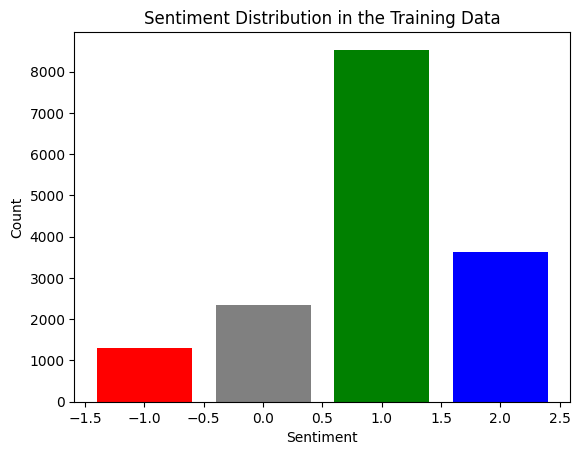

In [82]:
import matplotlib.pyplot as plt

# Count occurrences for each sentiment value
negative_count = (train['sentiment'] == -1).sum()
neutral_count = (train['sentiment'] == 0).sum()
positive_count = (train['sentiment'] == 1).sum()
positive_count2 = (train['sentiment'] == 2).sum()

print(negative_count)
print(neutral_count)
print(positive_count)
print(positive_count2)


# Data for the histogram
counts = [negative_count, neutral_count, positive_count, positive_count2]
sentiments = [-1, 0, 1, 2]

# Plot the histogram
plt.bar(sentiments, counts, color=['red', 'grey', 'green', 'blue'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution in the Training Data')
plt.show()


### Sentiment Definitions (from Kaggle)

#### 2 News: the tweet links to factual news about climate change

#### 1 Pro: the tweet supports the belief of man-made climate change

#### 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change

#### -1 Anti: the tweet does not believe in man-made climate change

## 4. Feature Engineering

#### Natural Language Processing

In [83]:


# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

## Remove urls
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
train['message'] = train['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

## Remove mentions
mention_pattern = r'@([^\s:]+)'
train['message'] = train['message'].replace(to_replace = mention_pattern, value = '', regex = True)

# Remove special charecters using regular expressions
pattern_special=r'[^a-zA-Z0-9\s]'
train['message'] = train['message'].replace(to_replace = pattern_special, value = '', regex = True)

# Lowercasing
train['Lowercased'] = train['message'].apply(lambda x: x.lower())

# Removing punctuation
train['No_Punctuation'] = train['Lowercased'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Tokenization
train['Tokenized'] = train['No_Punctuation'].apply(lambda x: word_tokenize(x))

# Stop words removal
stop_words = set(stopwords.words('english'))
train['No_Stopwords'] = train['Tokenized'].apply(lambda x: [word for word in x if word not in stop_words])

# Stemming
train['Stemmed'] = train['No_Stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])

# Lemmatization
train['Lemmatized'] = train['No_Stopwords'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

train['new_text_cleaned_l'] = train['Lemmatized'].apply(lambda words: ' '.join(words) )

train['new_text_cleaned_s'] = train['Stemmed'].apply(lambda words: ' '.join(words) )

In [84]:
train.head()

,sentiment,message,tweetid,Lowercased,No_Punctuation,Tokenized,No_Stopwords,Stemmed,Lemmatized,new_text_cleaned_l,new_text_cleaned_s
0,1,PolySciMajor EPA chief doesnt think carbon dio...,625221,polyscimajor epa chief doesnt think carbon dio...,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...",polyscimajor epa chief doesnt think carbon dio...,polyscimajor epa chief doesnt think carbon dio...
1,1,Its not like we lack evidence of anthropogenic...,126103,its not like we lack evidence of anthropogenic...,its not like we lack evidence of anthropogenic...,"[its, not, like, we, lack, evidence, of, anthr...","[like, lack, evidence, anthropogenic, global, ...","[like, lack, evid, anthropogen, global, warm]","[like, lack, evidence, anthropogenic, global, ...",like lack evidence anthropogenic global warming,like lack evid anthropogen global warm
2,2,RT Researchers say we have three years to act...,698562,rt researchers say we have three years to act...,rt researchers say we have three years to act...,"[rt, researchers, say, we, have, three, years,...","[rt, researchers, say, three, years, act, clim...","[rt, research, say, three, year, act, climat, ...","[rt, researcher, say, three, year, act, climat...",rt researcher say three year act climate chang...,rt research say three year act climat chang la...
3,1,TodayinMaker WIRED 2016 was a pivotal year in...,573736,todayinmaker wired 2016 was a pivotal year in...,todayinmaker wired 2016 was a pivotal year in...,"[todayinmaker, wired, 2016, was, a, pivotal, y...","[todayinmaker, wired, 2016, pivotal, year, war...","[todayinmak, wire, 2016, pivot, year, war, cli...","[todayinmaker, wired, 2016, pivotal, year, war...",todayinmaker wired 2016 pivotal year war clima...,todayinmak wire 2016 pivot year war climat cha...
4,1,RT Its 2016 and a racist sexist climate chang...,466954,rt its 2016 and a racist sexist climate chang...,rt its 2016 and a racist sexist climate chang...,"[rt, its, 2016, and, a, racist, sexist, climat...","[rt, 2016, racist, sexist, climate, change, de...","[rt, 2016, racist, sexist, climat, chang, deni...","[rt, 2016, racist, sexist, climate, change, de...",rt 2016 racist sexist climate change denying b...,rt 2016 racist sexist climat chang deni bigot ...


## Scikit-learn

In [95]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer instance
vectorizer = CountVectorizer(ngram_range=(1, 3))

# Fit and transform the documents
X = vectorizer.fit_transform(train['new_text_cleaned_s'])

# Print the CountVectorizer matrix and feature names
print("CountVectorizer Matrix:")
print(X.toarray())

CountVectorizer Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [96]:
# split up  data
from sklearn.model_selection import train_test_split
sentiments = train['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, sentiments, test_size = 0.2, random_state = 42)

In [97]:
# Define the logistic regression model
class_weights = class_weight.compute_class_weight('balanced', classes=sentiments.unique(), y=sentiments)
lr_model = LogisticRegression(max_iter=16000, class_weight=dict(zip(range(-1, 3), class_weights)))

# Resample the training data using Random Oversampling
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Train the model
lr_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Calculate classification report
report = classification_report(y_test, y_pred, target_names=['Anti', 'Neutral', 'Pro', 'News'])

# Perform cross-validation
cv_scores = cross_val_score(lr_model, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro')

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print class distribution
print("Class Distribution:")
print(train['sentiment'].value_counts())

# Print individual class metrics
print("Individual Class Metrics:")
print(report)

# Print overall accuracy
print("Overall Accuracy:", accuracy)

# Print cross-validation scores
print("Cross-validation Scores (F1 macro):", cv_scores)
print("Mean F1 macro:", np.mean(cv_scores))

Class Distribution:
sentiment
 1    8530
 2    3640
 0    2353
-1    1296
Name: count, dtype: int64
Individual Class Metrics:
              precision    recall  f1-score   support

        Anti       0.71      0.39      0.50       278
     Neutral       0.52      0.50      0.51       425
         Pro       0.79      0.81      0.80      1755
        News       0.72      0.81      0.76       706

    accuracy                           0.73      3164
   macro avg       0.68      0.63      0.64      3164
weighted avg       0.73      0.73      0.73      3164

Overall Accuracy: 0.7319848293299621
Cross-validation Scores (F1 macro): [0.9299556  0.92621203 0.93922603 0.93925148 0.93894154]
Mean F1 macro: 0.9347173372353735


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

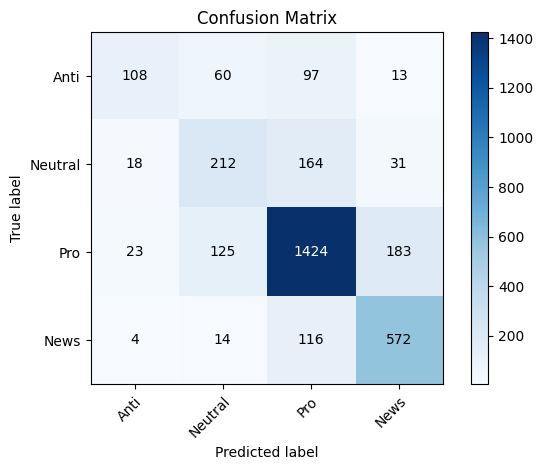

In [104]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Function to plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized Confusion Matrix'
        else:
            title = 'Confusion Matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
    
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=['Anti', 'Neutral', 'Pro', 'News'], title='Confusion Matrix')


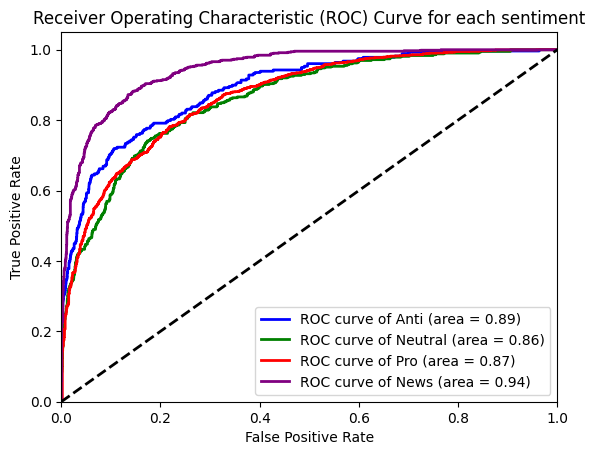

In [109]:
from sklearn.preprocessing import label_binarize

# Define the sentiment names
sentiment_names = {
    0: 'Anti',
    1: 'Neutral',
    2: 'Pro',
    3: 'News'
}

# Plot ROC curve for each class with sentiment names
plt.figure()
colors = ['blue', 'green', 'red', 'purple']
for i, color in zip(range(len(fpr)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(sentiment_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for each sentiment')
plt.legend(loc="lower right")
plt.show()

## Create a  ".CSV" File

In [114]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

## Remove urls
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
test['message'] = test['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

## Remove mentions
mention_pattern = r'@([^\s:]+)'
test['message'] = test['message'].replace(to_replace = mention_pattern, value = '', regex = True)

# Remove special charecters using regular expressions
pattern_special=r'[^a-zA-Z0-9\s]'
test['message'] = test['message'].replace(to_replace = pattern_special, value = '', regex = True)

# Lowercasing
test['Lowercased'] = test['message'].apply(lambda x: x.lower())

# Removing punctuation
test['No_Punctuation'] = test['Lowercased'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Tokenization
test['Tokenized'] = test['No_Punctuation'].apply(lambda x: word_tokenize(x))

# Stop words removal
stop_words = set(stopwords.words('english'))
test['No_Stopwords'] = test['Tokenized'].apply(lambda x: [word for word in x if word not in stop_words])

# Stemming
test['Stemmed'] = test['No_Stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])

# Lemmatization
test['Lemmatized'] = test['No_Stopwords'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

test['new_text_cleaned_l'] = test['Lemmatized'].apply(lambda words: ' '.join(words) )

test['new_text_cleaned_s'] = test['Stemmed'].apply(lambda words: ' '.join(words) )

In [115]:
test.head()

,message,tweetid,Lowercased,No_Punctuation,Tokenized,No_Stopwords,Stemmed,Lemmatized,new_text_cleaned_l,new_text_cleaned_s
0,Europe will now be looking to China to make su...,169760,europe will now be looking to china to make su...,europe will now be looking to china to make su...,"[europe, will, now, be, looking, to, china, to...","[europe, looking, china, make, sure, alone, fi...","[europ, look, china, make, sure, alon, fight, ...","[europe, looking, china, make, sure, alone, fi...",europe looking china make sure alone fighting ...,europ look china make sure alon fight climat c...
1,Combine this with the polling of staffers re c...,35326,combine this with the polling of staffers re c...,combine this with the polling of staffers re c...,"[combine, this, with, the, polling, of, staffe...","[combine, polling, staffers, climate, change, ...","[combin, poll, staffer, climat, chang, women, ...","[combine, polling, staffer, climate, change, w...",combine polling staffer climate change woman r...,combin poll staffer climat chang women right f...
2,The scary unimpeachable evidence that climate ...,224985,the scary unimpeachable evidence that climate ...,the scary unimpeachable evidence that climate ...,"[the, scary, unimpeachable, evidence, that, cl...","[scary, unimpeachable, evidence, climate, chan...","[scari, unimpeach, evid, climat, chang, alread...","[scary, unimpeachable, evidence, climate, chan...",scary unimpeachable evidence climate change al...,scari unimpeach evid climat chang alreadi urlw...
3,\nPutin got to you too Jill \nTrump doesn...,476263,\nputin got to you too jill \ntrump doesn...,\nputin got to you too jill \ntrump doesn...,"[putin, got, to, you, too, jill, trump, doesnt...","[putin, got, jill, trump, doesnt, believe, cli...","[putin, got, jill, trump, doesnt, believ, clim...","[putin, got, jill, trump, doesnt, believe, cli...",putin got jill trump doesnt believe climate ch...,putin got jill trump doesnt believ climat chan...
4,RT Female orgasms cause global warming\nSarca...,872928,rt female orgasms cause global warming\nsarca...,rt female orgasms cause global warming\nsarca...,"[rt, female, orgasms, cause, global, warming, ...","[rt, female, orgasms, cause, global, warming, ...","[rt, femal, orgasm, caus, global, warm, sarcas...","[rt, female, orgasm, cause, global, warming, s...",rt female orgasm cause global warming sarcasti...,rt femal orgasm caus global warm sarcast repub...


In [120]:
# Transform the preprocessed text into feature vectors
X_test = vectorizer.transform(test['new_text_cleaned_s'])

# Make predictions on the test data
test_predictions = lr_model.predict(X_test)

# Create a DataFrame with tweetid and predictions
results_df = pd.DataFrame({'tweetid': test['tweetid'], 'sentiment': test_predictions})

# Export the DataFrame to a CSV file
results_df.to_csv('test_predictions.csv', index=False)